# gwexpy.noise: 検出器および環境ノイズモデルの利用

このノートブックでは、`gwexpy.noise` サブパッケージを使用して、重力波検出器の設計感度や、地震・インフラサウンドなどの標準的な環境ノイズモデルを取得する方法を紹介します。

## 必要なライブラリのインポート

In [1]:
#import warnings
#from astropy.utils.exceptions import AstropyWarning
#warnings.filterwarnings("ignore", category=AstropyWarning)

import numpy as np
import matplotlib.pyplot as plt
from gwexpy.noise import from_pygwinc, from_obspy
from gwexpy.plot import Plot

plt.rcParams['figure.figsize'] = (10, 6)

## 1. 重力波検出器のノイズモデル (pygwinc 連携)

`from_pygwinc` 関数を使用すると、LIGO, Virgo, KAGRA などの検出器の設計感度（ASD: Amplitude Spectral Density）を `FrequencySeries` として取得できます。
※ この機能には `pygwinc` ライブラリのインストールが必要です。

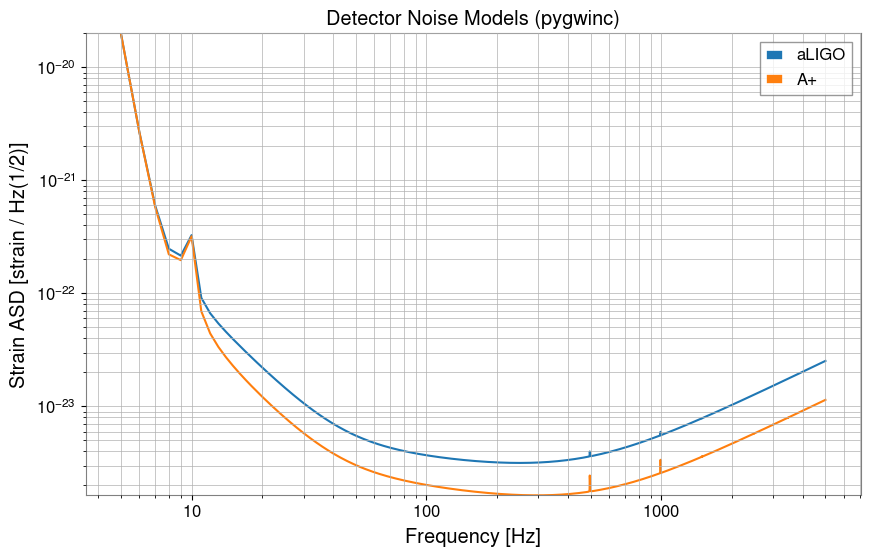

In [2]:
try:
    # aLIGO の設計感度を取得 (デフォルト: 10Hz - 4000Hz)
    asd_aligo = from_pygwinc('aLIGO', fmin=5, fmax=5000, df=1)

    # A+ 計画の感度を取得
    asd_aplus = from_pygwinc('A+', fmin=5, fmax=5000, df=1)

    # プロット
    plot = Plot(asd_aligo, asd_aplus, xscale='log', yscale='log')
    plt.ylabel(f'Strain ASD [{asd_aligo.unit}]')
    plt.grid(True, which='both')
    plt.legend(['aLIGO', 'A+'])
    plt.title('Detector Noise Models (pygwinc)')
    plt.show()
except ImportError:
    print("pygwinc がインストールされていないため、このセクションはスキップします。")

## 2. 地震およびインフラサウンドの標準ノイズモデル (ObsPy 連携)

`from_obspy` 関数を使用すると、ObsPy で提供されている標準的な地球ノイズモデル（NHNM/NLNM）やインフラサウンドのノイズモデルを取得できます。

- Seismic (地震): `NHNM` (New High Noise Model), `NLNM` (New Low Noise Model)
- Infrasound: `IDCH`, `IDCL` (IDC Infrasound High/Low Noise)

取得したデータは `FrequencySeries` となり、自動的に振幅スペクトル密度 (ASD) に変換されます。

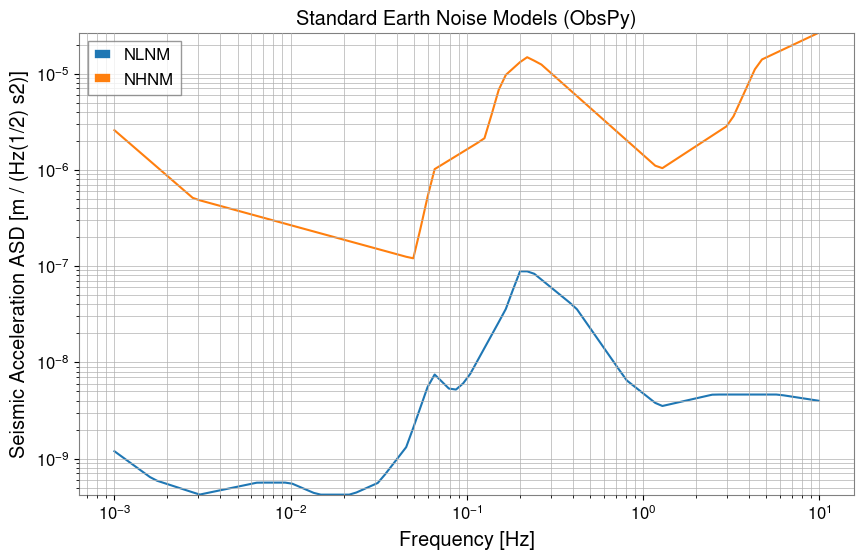

In [3]:
try:
    # 周波数軸を指定して NLNM (Low Noise Model) を取得
    freqs = np.logspace(-3, 1, 100)  # 1mHz - 10Hz
    nlnm = from_obspy('NLNM', frequencies=freqs)
    nhnm = from_obspy('NHNM', frequencies=freqs)

    # プロット (Base unit: m/s^2/sqrt(Hz))
    plot = Plot(nlnm, nhnm, xscale='log', yscale='log')
    plt.ylabel(f'Seismic Acceleration ASD [{nlnm.unit}]')
    plt.grid(True, which='both')
    plt.legend(['NLNM', 'NHNM'])
    plt.title('Standard Earth Noise Models (ObsPy)')
    plt.show()
except ImportError:
    print("obspy がインストールされていないため、このセクションはスキップします。")

### 単位変換と積分

`unit` 引数を指定すると、加速度から速度や変位への積分、および単位変換を自動的に行います。

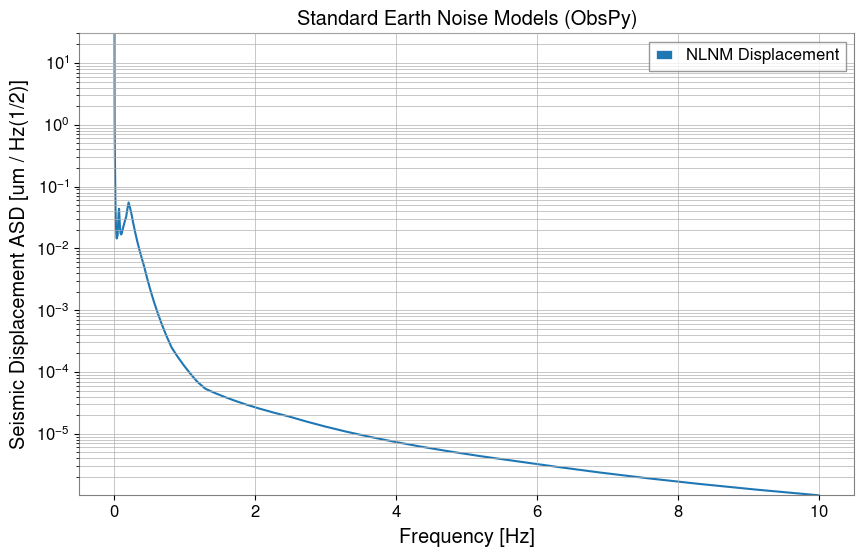

In [4]:
try:
    # 地震の「変位」ASD を nm/sqrt(Hz) で取得
    nlnm_disp = from_obspy('NLNM', frequencies=freqs, unit='um / Hz^(1/2)')

    # プロット
    plot = nlnm_disp.plot(label='NLNM Displacement')
    plt.ylabel(f'Seismic Displacement ASD [{nlnm_disp.unit}]')
    plt.grid(True, which='both')
    plt.legend()
    plt.title('Standard Earth Noise Models (ObsPy)')
    plt.show()
except ImportError:
    pass

## 3. インフラサウンド (気圧ノイズ)

IDC (International Data Centre) のインフラサウンド標準ノイズモデルも同様に取得できます。

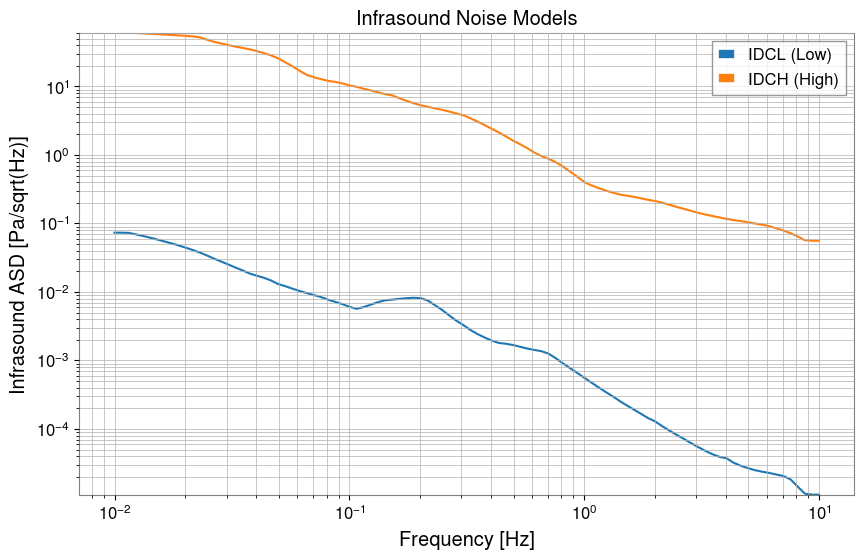

In [5]:
try:
    f_infra = np.logspace(-2, 1, 100)
    idcl = from_obspy('IDCL', frequencies=f_infra)
    idch = from_obspy('IDCH', frequencies=f_infra)

    # hPa への単位変換も可能
    idcl_hpa = from_obspy('IDCL', frequencies=f_infra, unit='hPa / Hz^(1/2)')

    plot = Plot(idcl, idch, xscale='log', yscale='log')
    plt.ylabel('Infrasound ASD [Pa/sqrt(Hz)]')
    plt.grid(True, which='both')
    plt.legend(['IDCL (Low)', 'IDCH (High)'])
    plt.title('Infrasound Noise Models')
    plt.show()
except ImportError:
    pass

## 5. 地磁気ノイズ (Geomagnetic Noise) の生成

地球規模の磁場変動として、**シューマン共振 (Schumann Resonance)** や **地磁気バックグラウンドノイズ (Geomagnetic Background)** を模擬する関数も利用可能です。

- `schumann_resonance`: 雷放電によって励起される地球-電離層間の空洞共振現象
- `geomagnetic_background`: 1/f 的なスペクトルを持つバックグラウンド磁場変動

これらは物理的に正しい合成を行うため、PSD (パワー) 空間での加算を行っています。

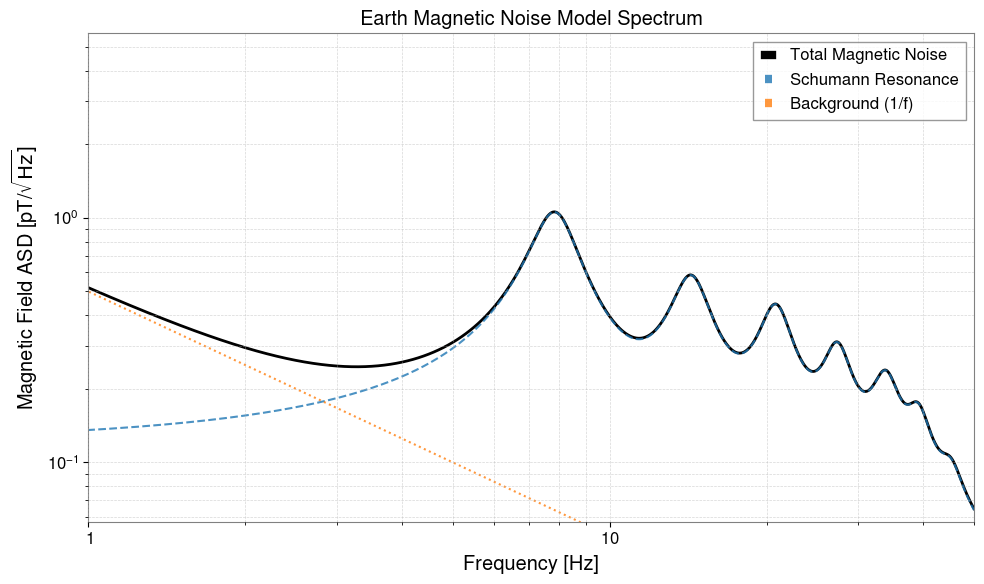

In [6]:
from gwexpy.noise import schumann_resonance, geomagnetic_background

# 周波数軸の設定 (0.1Hz - 50Hz)
frequencies = np.linspace(0.1, 50, 1000)

# シューマン共振の生成 (デフォルトモードを使用)
# 振幅スケールを調整可能
sr = schumann_resonance(frequencies, amplitude_scale=0.7, unit='pT/Hz^(1/2)')

# バックグラウンドノイズ (1/f ~ Pink noise)
bg = geomagnetic_background(frequencies, amplitude_1hz=0.5, exponent=1.0, unit='pT/Hz^(1/2)')

# 合成 (2乗和のルート = PSD加算)
total_noise = np.sqrt(sr**2 + bg**2)

# プロット
plot = Plot(total_noise, label='Total Magnetic Noise', color='black', linewidth=2)
plt.plot(sr, label='Schumann Resonance', linestyle='--', alpha=0.8)
plt.plot(bg, label='Background (1/f)', linestyle=':', alpha=0.8)

plt.yscale('log')
plt.ylabel(r'Magnetic Field ASD [pT/$\sqrt{\mathrm{Hz}}$]')
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.title('Earth Magnetic Noise Model Spectrum')
plt.xlim(1, 50)

plt.tight_layout()
plt.show()

## 4. 色付きノイズ (Colored Noise) の生成

`gwexpy.noise` モジュールでは、パワースペクトル密度が周波数のべき乗則に従う「色付きノイズ」($S(f) \propto 1/f^\alpha$) を生成する関数も提供しています。

- `white_noise`: 白色雑音 ($\alpha=0$)
- `pink_noise`: ピンクノイズ ($1/f$ ノイズ, $\alpha=1$)
- `red_noise`: レッドノイズ (ブラウンノイズ, $1/f^2$ ノイズ, $\alpha=2$)
- `power_law`: 任意のスペクトル指数 (ASDの指数) を指定可能

これらは `FrequencySeries` オブジェクト (ASD) を返します。

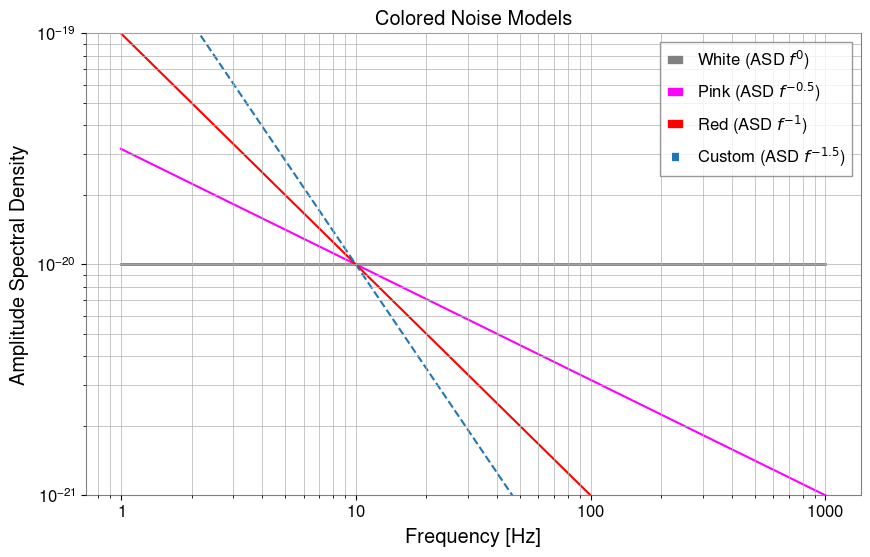

In [7]:
from gwexpy.noise import white_noise, pink_noise, red_noise, power_law

# 設定
frequencies = np.logspace(0, 3, 1000) # 1Hz - 1000Hz
amplitude = 1e-20 # 基準振幅

# ノイズ生成
# white: ASD ~ f^0 (フラット)
# frequencies は keyword argument として渡します
n_white = white_noise(amplitude, frequencies=frequencies, unit='strain/sqrt(Hz)')

# pink: ASD ~ 1/sqrt(f)  (PSD ~ 1/f)
n_pink = pink_noise(amplitude, frequencies=frequencies, unit='strain/sqrt(Hz)', f_ref=10)

# red: ASD ~ 1/f (PSD ~ 1/f^2)
n_red = red_noise(amplitude, frequencies=frequencies, unit='strain/sqrt(Hz)', f_ref=10)

# 任意のパワー則 (例: alpha=3 -> PSD ~ 1/f^3 -> ASD ~ 1/f^1.5)
# power_law(exponent, amplitude=..., f_ref=..., frequencies=...)
n_custom = power_law(1.5, amplitude=amplitude, frequencies=frequencies, unit='strain/sqrt(Hz)', f_ref=10)

# プロット
plot = Plot(n_white, label='White (ASD $f^0$)',color='gray', lw=2)
plt.plot(n_pink, label='Pink (ASD $f^{-0.5}$)',color='magenta')
plt.plot(n_red, label='Red (ASD $f^{-1}$)',color='red')
plt.plot(n_custom, label='Custom (ASD $f^{-1.5}$)', linestyle='--')

plt.xscale('log')
plt.yscale('log')
plt.ylabel('Amplitude Spectral Density')
plt.legend()
plt.grid(True, which='both')
plt.title('Colored Noise Models')
plt.show()